# Imports

In [46]:
# set up
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
import string 
from collections import defaultdict
from sklearn import metrics
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import scipy.optimize as sopt

# Macro for windows / mac users

In [47]:
system = 'Mac'
# system = 'Win'

# Preparing data (IMDb movies' reviews)

In [48]:
train_pos_path = 'data_sets/aclImdb/train/pos/*'
train_neg_path = 'data_sets/aclImdb/train/neg/*'

train_pos = glob.glob(train_pos_path)
train_neg = glob.glob(train_neg_path)


test_pos_path = 'data_sets/aclImdb/test/pos/*'
test_neg_path = 'data_sets/aclImdb/test/neg/*'

test_pos = glob.glob(test_pos_path)
test_neg = glob.glob(test_neg_path)

In [49]:
train_df = []
test_df = []

for path in tqdm(train_pos, desc='Getting positive train data', position=0, leave=False):
    with open(path, encoding="utf8") as f:
        text = f.read()
        
#         For win users
        if system == 'Win':
            beg, end = path.find('\\'), path.find('.')
        
#         For mac users
        if system == 'Mac':
            beg = re.search(r"\d",path).start()-1
            end = path.find('.')
            
        idx, rating = path[beg+1:-4].split('_')
        train_df.append([text, rating])
        
for path in tqdm(train_neg, desc='Getting negative train data', position=0, leave=False):
    with open(path, encoding="utf8") as f:
        text = f.read()
        
#         For win users
        if system == 'Win':
            beg, end = path.find('\\'), path.find('.')
        
#         For mac users
        if system == 'Mac':
            beg = re.search(r"\d",path).start()-1
            end = path.find('.')

        idx, rating = path[beg+1:-4].split('_')
        train_df.append([text, rating])
         
for path in tqdm(test_pos, desc='Getting positive test data', position=0, leave=False):
    with open(path, encoding="utf8") as f:
        text = f.read()
        
#         For win users
        if system == 'Win':
            beg, end = path.find('\\'), path.find('.')
        
#         For mac users
        if system == 'Mac':
            beg = re.search(r"\d",path).start()-1
            end = path.find('.')
            
        idx, rating = path[beg+1:-4].split('_')
        test_df.append([text, rating])
   
for path in tqdm(test_neg, desc='Getting negative test data', position=0, leave=False):
    with open(path, encoding="utf8") as f:
        text = f.read()

#         For win users
        if system == 'Win':
            beg, end = path.find('\\'), path.find('.')
        
#         For mac users
        if system == 'Mac':
            beg = re.search(r"\d",path).start()-1
            end = path.find('.')
            
        idx, rating = path[beg+1:-4].split('_')
        test_df.append([text, rating])

In [50]:
train_df = pd.DataFrame(train_df, columns=['text', 'rating'])
test_df = pd.DataFrame(test_df, columns=['text', 'rating'])

In [51]:
print('Records: ', train_df.size)
train_df.head()

Records:  50000


,text,rating
0,For a movie that gets no respect there sure ar...,9
1,Bizarre horror movie filled with famous faces ...,8
2,"A solid, if unremarkable film. Matthau, as Ein...",7
3,It's a strange feeling to sit alone in a theat...,8
4,"You probably all already know this by now, but...",10


In [52]:
for i in range(1, 11):
    print(f'Number of reviews with rating {i}: {train_df[train_df.rating == str(i)].shape[0]}')

Number of reviews with rating 1: 5100
Number of reviews with rating 2: 2284
Number of reviews with rating 3: 2420
Number of reviews with rating 4: 2696
Number of reviews with rating 5: 0
Number of reviews with rating 6: 0
Number of reviews with rating 7: 2496
Number of reviews with rating 8: 3009
Number of reviews with rating 9: 2263
Number of reviews with rating 10: 4732


# Clean and Preprocess

In [53]:
def regex(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

## Remove punctuation

In [54]:
%%time
# Remove punctuaction and lower all texts
train_df.text = train_df.text.apply(lambda row: regex(row))
test_df.text = test_df.text.apply(lambda row: regex(row))

CPU times: user 2.4 s, sys: 61.8 ms, total: 2.46 s
Wall time: 2.58 s


In [55]:
train_df.head()

,text,rating
0,for a movie that gets no respect there sure ar...,9
1,bizarre horror movie filled with famous faces ...,8
2,a solid if unremarkable film matthau as einste...,7
3,its a strange feeling to sit alone in a theate...,8
4,you probably all already know this by now but ...,10


In [11]:
# consider only rating 1 and 10
bayes_df_train = train_df[(train_df.rating == '1') | (train_df.rating == '10')]
bayes_df_test = test_df[(test_df.rating == '1') | (test_df.rating == '10')]

## Stem

In [12]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

In [13]:
def stem_(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [16]:
stemmed_train_df = bayes_df_train.copy()
stemmed_test_df = bayes_df_test.copy()
stemmed_train_df.text = stemmed_train_df.text.apply(lambda row: stem_(row))
stemmed_test_df.text = stemmed_test_df.text.apply(lambda row: stem_(row))

## Remove stop words

In [14]:
def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

In [17]:
swr_train_df = bayes_df_train.copy()
swr_test_df = bayes_df_test.copy()
swr_train_df.text = swr_train_df.text.apply(lambda row: remove_stop_words(row))
swr_test_df.text = swr_test_df.text.apply(lambda row: remove_stop_words(row))

In [15]:
def stem_and_remove_stop_words(text):
    return ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])

In [18]:
stemmed_swr_train_df = bayes_df_train.copy()
stemmed_swr_test_df = bayes_df_test.copy()
stemmed_swr_train_df.text = stemmed_swr_train_df.text.apply(lambda row: stem_(row))
stemmed_swr_test_df.text = stemmed_swr_test_df.text.apply(lambda row: stem_(row))

## Score visualization

In [150]:
def print_score(preds,Y,name):
    print(name)
    acc = np.mean(preds == Y)
    print(f"Acc: {acc}")
    M = metrics.confusion_matrix(preds,Y)
    N = np.sum(M)
    print('\nConfusion matrix:')
    print(M)
    print(f'\nTrue negative (rating = 1): {M[0][0]}')
    print(f'True positive (rating = 10): {M[1][1]}')
    print(f'False negative: {M[0][1]}')
    print(f'False positive: {M[1][0]}')
    return M,N,acc

# CountVectorizer

In [222]:
class MyCountVectorizer:
    def __init__(self, min_df=-1, max_df=1e18, binary=False):
        self.min_df = min_df
        self.max_df = max_df
        self.binary = binary
    
    def fit(self, df):
        words_cnt = defaultdict(int)
        col = df.columns[0]
        
        for i in range(len(df)):
            text = df.iloc[i][col]
            for word in text.split():
                words_cnt[word] += 1
                
        all_words = []
        for word, cnt in words_cnt.items():
            if self.min_df <= cnt <= self.max_df:
                all_words.append(word)
                
        self.all_words_ids = {w:i for i,w in enumerate(all_words)}
        self.width = len(all_words)
        
    
    def transform(self, df):
        col = df.columns[0]
        count_matrix = np.zeros([len(df), self.width], \
                                dtype=np.int32)
        
        for i in range(len(df)):
            text = df.iloc[i][col]
            words_cnt = defaultdict(int)
            
            for word in text.split():
                words_cnt[word] += 1
            
            for word, cnt in words_cnt.items():
                if word in self.all_words_ids:
                    pos = self.all_words_ids[word]
                    if self.binary:
                        count_matrix[i][pos] = 1
                    else:
                        count_matrix[i][pos] = cnt
                    
        return count_matrix

# Naive Bayes

## Naive Bayes class

In [19]:
class Naive_Bayes:
    def __init__(self,alpha=0,fit_prior=True,class_prior=None):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior_array = class_prior
        if class_prior:
            self.fit_prior = False
    
    
    def fit(self,X,y):
        self.classes,prior = np.unique(y,return_counts=True)
        self.N = len(y)
        
        # Setting class prior
        if self.fit_prior:
            self.class_prior = {class_ : np.log(prior[i]/self.N + 1e-100)
                                for i,class_ in enumerate(self.classes)}
        elif self.class_prior_array:
            self.class_prior = {class_ : np.log(self.class_prior_array[i] + 1e-100) 
                                for i,class_ in enumerate(self.classes)}
        else:
            self.class_prior = {class_ : np.log(1/len(self.classes) + 1e-100) 
                                for class_ in self.classes}
            
        # Creating words dictionaries
        self.class_words_counts = {class_ : defaultdict(lambda: 0) 
                                   for class_ in self.classes}
        for i,text in enumerate(X):
            target = y[i]
            for word in text.split():
                self.class_words_counts[target][word] += 1
        
        # Creating probabilities dictionaries
        self.class_words_probs = {class_ : defaultdict(lambda: np.log(self.alpha + 1e-100)) 
                                  for class_ in self.classes}
        for class_,dict_ in self.class_words_counts.items():
            for word,count in dict_.items():
                self.class_words_probs[class_][word] = np.log(count + 1e-100)
    
        self.class_words_amount = {class_ : np.log(sum(self.class_words_counts[class_].values())) 
                                   for class_ in self.classes}
    

    def get_class_log_probabilities(self,text):
        probs = {class_ : 0 for class_ in self.classes}
        for class_ in self.classes:
            for word in text.split():
                probs[class_] += self.class_words_probs[class_][word]
                probs[class_] -= self.class_words_amount[class_]
            probs[class_] += self.class_prior[class_]
        return probs
    
    
    def predict(self,X,return_probabilities = False):
        preds = []
        preds_probs = []
        for text in X:
            prob = self.get_class_log_probabilities(text)
            #prob = {class_ : np.exp(pbb) for class_,pbb in prob.items()}
            preds_probs.append(prob)
            pred = max(prob,key = prob.get)
            preds.append(pred)
        
        if return_probabilities:
            return preds,preds_probs
        return preds


## Train and test accuracy

In [177]:
X_train,y_train = np.array(bayes_df_train['text']),np.array(bayes_df_train['rating'])
X_test,y_test = np.array(bayes_df_test['text']),np.array(bayes_df_test['rating'])

In [178]:
NBc_res = []

In [179]:
alpha = 1.5
NB = Naive_Bayes(fit_prior = False,alpha=alpha)

In [180]:
NB.fit(X_train,y_train)

In [181]:
predictions,ppb = NB.predict(X_train,return_probabilities=True)

In [182]:
M,N,acc = print_score(predictions,y_train,f"TRAIN, alpha : {alpha}")
NBc_res.append(['Org train data\na=1.5','Acc',acc])
NBc_res.append(['Org train data\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Org train data\na=1.5','FP',M[1][0]/N])

TRAIN, alpha : 1.5
Acc: 0.9363303498779495

Confusion matrix:
[[4904  430]
 [ 196 4302]]

True negative (rating = 1): 4904
True positive (rating = 10): 4302
False negative: 430
False positive: 196


In [183]:
predictions,ppb = NB.predict(X_test,return_probabilities=True)

In [184]:
M,N,acc = print_score(predictions,y_test,f"TEST, alpha : {alpha}")
NBc_res.append(['Org test data\na=1.5','Acc',acc])
NBc_res.append(['Org test data\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Org test data\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5
Acc: 0.8893324019558926

Confusion matrix:
[[4651  738]
 [ 371 4261]]

True negative (rating = 1): 4651
True positive (rating = 10): 4261
False negative: 738
False positive: 371


Now we can try use alpha = 0

In [185]:
alpha = 0.0
NB = Naive_Bayes(fit_prior = False,alpha=alpha)

In [186]:
NB.fit(X_train,y_train)

In [187]:
predictions,ppb = NB.predict(X_train,return_probabilities=True)

In [188]:
M,N,acc = print_score(predictions,y_train,f"TRAIN, alpha : {alpha}")

TRAIN, alpha : 0.0
Acc: 0.9899308380797396

Confusion matrix:
[[5092   91]
 [   8 4641]]

True negative (rating = 1): 5092
True positive (rating = 10): 4641
False negative: 91
False positive: 8


In [189]:
predictions,ppb = NB.predict(X_test,return_probabilities=True)

In [190]:
M,N,acc = print_score(predictions,y_test,f"TEST, alpha : {alpha}")

TEST, alpha : 0.0
Acc: 0.7240794331903003

Confusion matrix:
[[3932 1675]
 [1090 3324]]

True negative (rating = 1): 3932
True positive (rating = 10): 3324
False negative: 1675
False positive: 1090


Setting alpha to 0 improve our train accuracy, but decrease train accuracy, so it`s overfitting. 
We can try to find best alpha for our data.

## Testing different alphas

In [191]:
for alpha in [0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,3.0,4.0,5.0,10.0]:
    NB = Naive_Bayes(fit_prior = False,alpha=alpha)
    NB.fit(X_train,y_train)
    predictions,ppb = NB.predict(X_test,return_probabilities=True)
    acc = np.mean(predictions == y_test)
    print(f'Alpha : {alpha}, test acc: {acc}')

Alpha : 0.0, test acc: 0.7240794331903003
Alpha : 0.25, test acc: 0.8820476998303562
Alpha : 0.5, test acc: 0.8868376409539966
Alpha : 0.75, test acc: 0.8882347071150584
Alpha : 1.0, test acc: 0.8884342879952101
Alpha : 1.25, test acc: 0.8881349166749826
Alpha : 1.5, test acc: 0.8893324019558926
Alpha : 1.75, test acc: 0.8884342879952101
Alpha : 2.0, test acc: 0.8882347071150584
Alpha : 3.0, test acc: 0.8872368027142999
Alpha : 4.0, test acc: 0.8862388983135415
Alpha : 5.0, test acc: 0.8830456042311147
Alpha : 10.0, test acc: 0.8759604829857299


## Stemming and stop words removing

In [192]:
alpha = 1.5

In [193]:
NB = Naive_Bayes(fit_prior = False,alpha=alpha)
NB.fit(np.array(stemmed_train_df['text']),np.array(stemmed_train_df['rating']))
predictions = NB.predict(np.array(stemmed_test_df['text']))
M,N,acc = print_score(predictions,np.array(stemmed_test_df['rating']),
                      f"TEST, alpha : {alpha}, stemmed")
NBc_res.append(['Stemmed test data\na=1.5','Acc',acc])
NBc_res.append(['Stemmed test data\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Stemmed test data\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stemmed
Acc: 0.8827462329108872

Confusion matrix:
[[4623  776]
 [ 399 4223]]

True negative (rating = 1): 4623
True positive (rating = 10): 4223
False negative: 776
False positive: 399


In [194]:
NB = Naive_Bayes(fit_prior = False,alpha=alpha)
NB.fit(np.array(swr_train_df['text']),np.array(swr_test_df['rating']))
predictions = NB.predict(np.array(swr_test_df['text']))
M,N,acc = print_score(predictions,np.array(stemmed_test_df['rating']),
                      f"TEST, alpha : {alpha}, stop words removed")
NBc_res.append(['Test data\nwithout stopwords\na=1.5','Acc',acc])
NBc_res.append(['Test data\nwithout stopwords\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Test data\nwithout stopwords\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stop words removed
Acc: 0.8995110268436284

Confusion matrix:
[[4656  641]
 [ 366 4358]]

True negative (rating = 1): 4656
True positive (rating = 10): 4358
False negative: 641
False positive: 366


In [195]:
NB = Naive_Bayes(fit_prior = False,alpha=alpha)
NB.fit(np.array(stemmed_swr_train_df['text']),np.array(stemmed_swr_train_df['rating']))
predictions = NB.predict(np.array(stemmed_swr_test_df['text']))
M,N,acc = print_score(predictions,np.array(stemmed_test_df['rating']),
                      f"TEST, alpha : {alpha}, stemmed and stop words removed")
NBc_res.append(['Stemmed test data\nwithout stop words\na=1.5','Acc',acc])
NBc_res.append(['Stemmed test data\nwithout stop words\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Stemmed test data\nwithout stop words\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stemmed and stop words removed
Acc: 0.8827462329108872

Confusion matrix:
[[4623  776]
 [ 399 4223]]

True negative (rating = 1): 4623
True positive (rating = 10): 4223
False negative: 776
False positive: 399


In [196]:
NBc_res_df = pd.DataFrame(NBc_res,columns = ['Data','Y','Value'])

Text(0.5, 1, 'Our Naive Bayes class')

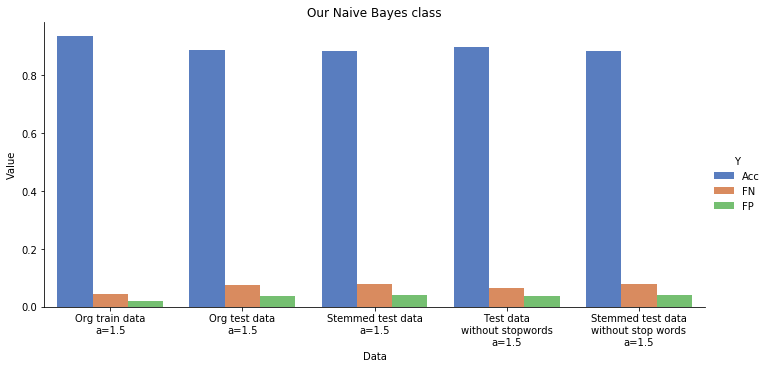

In [244]:
sns.catplot(x="Data", y="Value", hue="Y", data=NBc_res_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Our Naive Bayes class")

## Compare with Sklearn Naive Bayes

In [228]:
NBb_res = []

In [229]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(bayes_df_train['text']),np.array(bayes_df_train['rating'])
X_test,y_test = np.array(bayes_df_test['text']),np.array(bayes_df_test['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [230]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_train_cv)
M,N,acc = print_score(predictions,y_train,f"TRAIN, alpha : {alpha}")
NBb_res.append(['Org train data\na=1.5','Acc',acc])
NBb_res.append(['Org train data\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Org train data\na=1.5','FP',M[1][0]/N])

TRAIN, alpha : 1.5
Acc: 0.9509764035801465

Confusion matrix:
[[5009  391]
 [  91 4341]]

True negative (rating = 1): 5009
True positive (rating = 10): 4341
False negative: 391
False positive: 91


In [231]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,f"TEST, alpha : {alpha}")
NBb_res.append(['Org test data\na=1.5','Acc',acc])
NBb_res.append(['Org test data\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Org test data\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5
Acc: 0.884742041712404

Confusion matrix:
[[4738  871]
 [ 284 4128]]

True negative (rating = 1): 4738
True positive (rating = 10): 4128
False negative: 871
False positive: 284


In [232]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(stemmed_train_df['text']),np.array(stemmed_train_df['rating'])
X_test,y_test = np.array(stemmed_test_df['text']),np.array(stemmed_test_df['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [233]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,
                      f"TEST, alpha : {alpha}, stemmed")
NBb_res.append(['Stemmed test data\na=1.5','Acc',acc])
NBb_res.append(['Stemmed test data\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Stemmed test data\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stemmed
Acc: 0.8805508432292186

Confusion matrix:
[[4710  885]
 [ 312 4114]]

True negative (rating = 1): 4710
True positive (rating = 10): 4114
False negative: 885
False positive: 312


In [234]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(swr_train_df['text']),np.array(swr_train_df['rating'])
X_test,y_test = np.array(swr_test_df['text']),np.array(swr_test_df['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [235]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,
                      f"TEST, alpha : {alpha}, stemmed")
NBb_res.append(['Test data\nwithout stopwords\na=1.5','Acc',acc])
NBb_res.append(['Test data\nwithout stopwords\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Test data\nwithout stopwords\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stemmed
Acc: 0.8932242291188505

Confusion matrix:
[[4752  800]
 [ 270 4199]]

True negative (rating = 1): 4752
True positive (rating = 10): 4199
False negative: 800
False positive: 270


In [236]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(stemmed_swr_train_df['text']),np.array(stemmed_swr_train_df['rating'])
X_test,y_test = np.array(stemmed_swr_test_df['text']),np.array(stemmed_swr_test_df['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [237]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,
                      f"TEST, alpha : {alpha}, stemmed")
NBb_res.append(['Stemmed test data\nwithout stop words\na=1.5','Acc',acc])
NBb_res.append(['Stemmed test data\nwithout stop words\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Stemmed test data\nwithout stop words\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stemmed
Acc: 0.8805508432292186

Confusion matrix:
[[4710  885]
 [ 312 4114]]

True negative (rating = 1): 4710
True positive (rating = 10): 4114
False negative: 885
False positive: 312


In [238]:
NBb_res_df = pd.DataFrame(NBb_res,columns = ['Data','Y','Value'])

Text(0.5, 1, 'Sklearn MultinomialNaiveBayes')

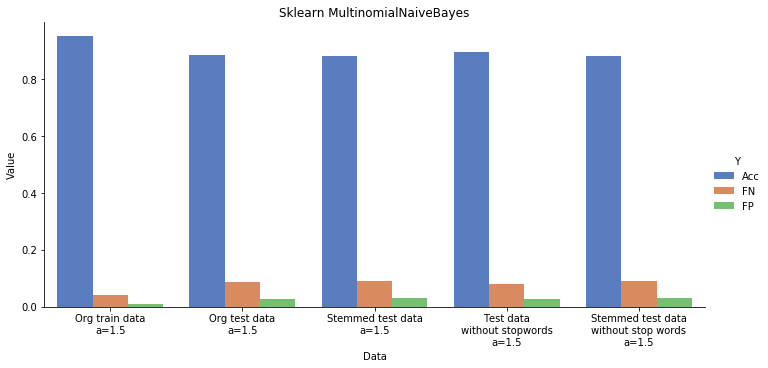

In [242]:
sns.catplot(x="Data", y="Value", hue="Y", data=NBb_res_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Sklearn MultinomialNaiveBayes")

In [253]:
NBc_res_df_copyed = NBc_res_df.copy()
A_df = NBc_res_df[NBc_res_df.Y == 'Acc']
A_df.Y = ['Our'] * 5

In [254]:
NBb_res_df_copyed = NBb_res_df.copy()
B_df = NBb_res_df[NBb_res_df.Y == 'Acc']
B_df.Y = ['Sklearn'] * 5

In [255]:
compare_df = pd.concat([A_df,B_df])

Text(0.5, 1, 'Sklearn MultinomialNaiveBayes')

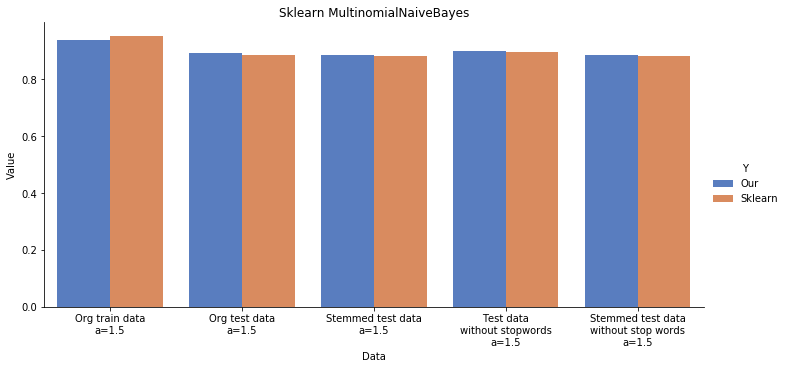

In [257]:
sns.catplot(x="Data", y="Value", hue="Y", data=compare_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Our Naive Bayes class vs Sklearn MultinomialNaiveBayes")

# Logistic Regression

## Logistic Regression class

In [287]:
class Logistic_Regression:
    def __init__(self, max_iter=500, solver_calls=5, Theta=None, solver=sopt.fmin_l_bfgs_b, debug=False):
        self.Theta = Theta
        self.solver_calls = solver_calls
        self.max_iter = max_iter
        self.solver = solver
        self.debug = debug
    
    def __sigmoid(self,x):
        return 1 / (1 + np.exp(-x))    
    
    def __logreg_loss(self, Theta, X, Y):
        Theta = Theta.astype(np.float64)
        X = X.astype(np.float64)
        Y = Y.astype(np.float64)
        
        if self.debug:
            print(f"Loss calculating... ",end="")
        Z = np.dot(Theta,X.T)
        if self.debug:
            print(f" Z done... ",end="")
        SZ = self.__sigmoid(Z)
        nll = -np.sum([
                        y * np.log2(SZ + 1e-7) \
                        + (1-y) * np.log2(1 - SZ + 1e-7) \
                        for y in Y
                        ])
        if self.debug:
            print(f" nll done... ",end="")
        grad = np.dot(X.T, (SZ - Y).T )
        if self.debug:
            print(f" grad done... done ")
        return nll, grad.reshape(Theta.shape)
    
    def fit(self,X,y):
        Theta = self.Theta
        if Theta is None:
            Theta = np.ones(X.shape[1])
      
        for i in range(self.solver_calls):
            Theta = self.solver(lambda th: self.__logreg_loss(th, X, y), Theta, maxiter=self.max_iter)[0]
        self.Theta = Theta
    
    def __logreg_classify(self, x):
        return (self.Theta.T.dot(x) >= 0)

    def predict(self, Xs):
        return [self.__logreg_classify(x) for x in Xs]

## Train and test accuracy

In [169]:
'''
Zmiany:
- klasa Vectorizer
- klasa logic reg
'''

'\nZmiany:\n- klasa Vectorizer\n- klasa logic reg\n'

In [292]:
# Theta = pd.read_csv('Theta.csv')['0']

In [332]:
LGc_res = []

y_train = np.array(list(map(int, bayes_df_train['rating']))) // 10
y_test = np.array(list(map(int, bayes_df_test['rating']))) // 10

In [333]:
%%time
cv = MyCountVectorizer(min_df=5)
cv.fit(bayes_df_train)

X_train = cv.transform(bayes_df_train) 
X_test = cv.transform(bayes_df_test)

CPU times: user 9.41 s, sys: 447 ms, total: 9.86 s
Wall time: 10 s


In [334]:
X_train.shape

(9832, 17232)

In [335]:
%%time
LR = Logistic_Regression(max_iter=1, solver_calls=1, debug=True)
LR.fit(X_train, y_train)

Loss calculating...  Z done...  nll done...  grad done... done 
Loss calculating...  Z done...  nll done...  grad done... done 
Loss calculating...  Z done...  nll done...  grad done... done 
Loss calculating...  Z done... 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


 nll done...  grad done... done 
Loss calculating...  Z done...  nll done...  grad done... done 
CPU times: user 18.6 s, sys: 6.99 s, total: 25.6 s
Wall time: 23.5 s


In [336]:
LR.Theta

array([0.10636492, 0.92806863, 0.36798298, ..., 0.99932012, 0.99932012,
       0.99932012])

In [337]:
LR.Theta.shape

(17232,)

In [338]:
X_train.shape

(9832, 17232)

In [339]:
predictions = LR.predict(X_train)

In [340]:
M, N, acc = print_score(predictions, y_train, 'TRAIN')
LGc_res.append(['Org train data\n','Acc',acc])
LGc_res.append(['Org train data\n','FN',M[0][1]/N])
LGc_res.append(['Org train data\n','FP',M[1][0]/N])

TRAIN
Acc: 0.5117982099267697

Confusion matrix:
[[4706 4406]
 [ 394  326]]

True negative (rating = 1): 4706
True positive (rating = 10): 326
False negative: 4406
False positive: 394


In [341]:
predictions = LR.predict(X_test)

In [342]:
M, N, acc = print_score(predictions, y_test, 'TEST')
LGc_res.append(['Org test data\n','Acc',acc])
LGc_res.append(['Org test data\n','FN',M[0][1]/N])
LGc_res.append(['Org test data\n','FP',M[1][0]/N])

TEST
Acc: 0.4988524099391278

Confusion matrix:
[[4686 4686]
 [ 336  313]]

True negative (rating = 1): 4686
True positive (rating = 10): 313
False negative: 4686
False positive: 336


## Stemming and stop words removal

In [343]:
%%time
cv = MyCountVectorizer(min_df=5)
cv.fit(stemmed_swr_train_df)

X_train = cv.transform(stemmed_swr_train_df) 
X_test = cv.transform(stemmed_swr_test_df)

CPU times: user 9.62 s, sys: 441 ms, total: 10.1 s
Wall time: 10.3 s


In [344]:
X_train.shape

(9832, 12649)

In [347]:
%%time
LR = Logistic_Regression(max_iter=1, solver_calls=1, debug=True)
LR.fit(X_train, y_train)

Loss calculating...  Z done...  nll done...  grad done... done 
Loss calculating...  Z done...  nll done...  grad done... done 
Loss calculating...  Z done...  nll done...  grad done... done 
Loss calculating...  Z done... 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


 nll done...  grad done... done 
Loss calculating...  Z done...  nll done...  grad done... done 
CPU times: user 17.1 s, sys: 5.62 s, total: 22.8 s
Wall time: 20.8 s


In [355]:
predictions = LR.predict(X_train)

In [356]:
M, N, acc = print_score(predictions, y_train, 'TRAIN')
LGc_res.append(['Stemmed train data\nwithout stop words\n','Acc',acc])
LGc_res.append(['Stemmed train data\nwithout stop words\n','FN',M[0][1]/N])
LGc_res.append(['Stemmed train data\nwithout stop words\n','FP',M[1][0]/N])

TRAIN
Acc: 0.5143409275834011

Confusion matrix:
[[4785 4460]
 [ 315  272]]

True negative (rating = 1): 4785
True positive (rating = 10): 272
False negative: 4460
False positive: 315


In [357]:
predictions = LR.predict(X_test)

In [358]:
M, N, acc = print_score(predictions, y_test, 'TEST')
LGc_res.append(['Stemmed test data\nwithout stop words\n','Acc',acc])
LGc_res.append(['Stemmed test data\nwithout stop words\n','FN',M[0][1]/N])
LGc_res.append(['Stemmed test data\nwithout stop words\n','FP',M[1][0]/N])

TEST
Acc: 0.500648637860493

Confusion matrix:
[[4751 4733]
 [ 271  266]]

True negative (rating = 1): 4751
True positive (rating = 10): 266
False negative: 4733
False positive: 271


In [361]:
LGc_res_df = pd.DataFrame(LGc_res,columns = ['Data','Y','Value'])

Text(0.5, 1, 'Our Naive Bayes class')

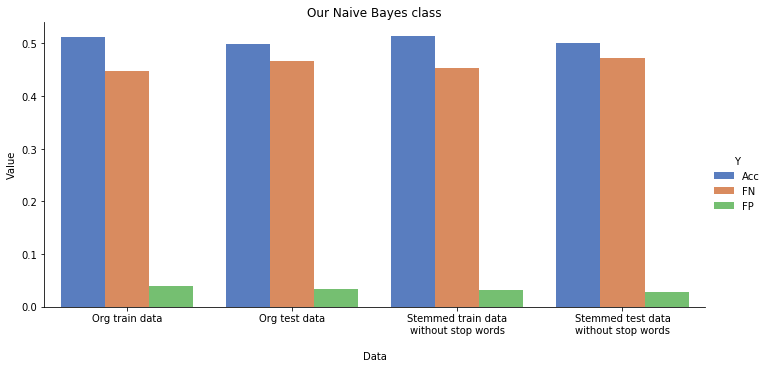

In [362]:
sns.catplot(x="Data", y="Value", hue="Y", data=LGc_res_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Our Naive Bayes class")

## Compare with sklearn Linear Regression

### 5.1 Data vectorization (one-hot encoding)

In [22]:
reviews_train_clean = np.array(train_df.text)
reviews_test_clean = np.array(test_df.text)
cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)

In [23]:
target = [1 if i < 12500 else 0 for i in range(25000)]

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:    
    lr = LogisticRegression(C=c,max_iter=300) # pobawic sie parametrami znalezc najlepsze
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.86576
Accuracy for C=0.05: 0.87856
Accuracy for C=0.25: 0.8784
Accuracy for C=0.5: 0.87648
Accuracy for C=1: 0.87504


# Text Preprocessing
Removing stop words, stemming, encode review as a vector of words occurences

In [24]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [25]:
# We will be using reviews with rating equal 1 or 10 from training set. 
# Test samples rating will be also classified as 1 or 10
LR_train_df = train_df[(train_df.rating == '1') | (train_df.rating == '10')]
LR_test_df = test_df[(test_df.rating == '1') | (test_df.rating == '10')]

In [26]:
LR_train_target = np.array([int(r) for r in LR_train_df['rating']]) // 10
LR_test_target = np.array([int(r) for r in LR_test_df['rating']]) // 10

In [27]:
LR_train_df.shape

(9832, 2)

In [28]:
stemmer = SnowballStemmer("english")
stopwords_set = set(stopwords.words('english'))

In [29]:
def preprocess(sample):
    words = sample.split()
    words = [ stemmer.stem(word) for word in words if word not in stopwords_set ]
    return words

In [30]:
# sample from train set
sample = '''brilliant overacting by lesley ann warren best dramatic hobo lady i 
have ever seen and love scenes in clothes warehouse are second to none the corn 
on face is a classic as good as anything in blazing saddles the take on lawyers 
is also superb after being accused of being a turncoat selling out his boss and 
being dishonest the lawyer of pepto bolt shrugs indifferently im a lawyer he says 
three funny words jeffrey tambor a favorite from the later larry sanders show is 
fantastic here too as a mad millionaire who wants to crush the ghetto his character 
is more malevolent than usual the hospital scene and the scene where the homeless 
invade a demolition site are alltime classics look for the legs scene and the two 
big diggers fighting one bleeds this movie gets better each time i see it which is 
quite often'''

In [31]:
" ".join(preprocess(sample))

'brilliant overact lesley ann warren best dramat hobo ladi ever seen love scene cloth warehous second none corn face classic good anyth blaze saddl take lawyer also superb accus turncoat sell boss dishonest lawyer pepto bolt shrug indiffer im lawyer say three funni word jeffrey tambor favorit later larri sander show fantast mad millionair want crush ghetto charact malevol usual hospit scene scene homeless invad demolit site alltim classic look leg scene two big digger fight one bleed movi get better time see quit often'

In [32]:
words = {}

In [33]:
%%time
for i in LR_train_df.index:
    sample = LR_train_df.loc[i]['text']
    #words |= set(preprocess(sample)) <- for set of words
    for word in preprocess(sample):
        words[word] = words.get(word,0) + 1

Wall time: 32.1 s


In [34]:
# from all stemmed words we consider only those, which occurs more than k times
min_occur = 3
all_train_words = list(filter(lambda w: words[w] >= min_occur,words))
n_w = len(all_train_words)
n_w

17385

In [35]:
all_train_words_indexes = {w:i for i,w in enumerate(all_train_words)}

In [36]:
def vectorize(df):
    data = []
    for i in df.index:
        v = np.zeros(n_w+1, dtype=np.int32)
        v[0] = 1
        sample = df.loc[i]['text']
        words = preprocess(sample)
        for word in words:
            idx = all_train_words_indexes.get(word,-1)
            if idx >= 0:
                v[idx+1] += 1
        data.append(v)
    return np.array(data)

In [37]:
vectorized_train = vectorize(LR_train_df)

In [38]:
vectorized_train.shape

(9832, 17386)

# 6. Logistic Regression Class

In [1]:
class Logistic_Regression:
    def __init__(self,max_iter = 500,solver_calls = 5,Theta = None,solver = sopt.fmin_l_bfgs_b):
        self.Theta = Theta
        self.solver_calls = solver_calls
        self.max_iter = max_iter
        self.solver = solver
    
    def __sigmoid(self,x):
        return 1 / (1 + np.exp(-x))    
    
    def __logreg_loss(self,Theta, X, Y):
        print(f"Loss calculating... ",end="")
        Z = np.dot(Theta,X.T)
        print(f" Z done... ",end="")
        SZ = self.__sigmoid(Z)
        nll = -np.sum([
                        y * np.log2(SZ + 1e-7) \
                        + (1-y) * np.log2(1 - SZ + 1e-7) \
                        for y in Y
                        ])
        print(f" nll done... ",end="")
        grad = np.dot(X.T, (SZ - Y).T )
        print(f" grad done... done ")
        return nll, grad.reshape(Theta.shape)
    
    def fit(self,X,y):
        Theta = self.Theta
        if Theta is None:
            Theta = np.ones(X.shape[1])
        for i in range(self.solver_calls):
            Theta = self.solver(lambda th: self.__logreg_loss(th, X, y), Theta, maxiter=self.max_iter)[0]
        self.Theta = Theta
    
    def __logreg_classify(self,x):
        return (self.Theta.T.dot(x) >= 0)

    def predict(self,Xs):
        return [logreg_classify(self.Theta,x) for x in Xs]

NameError: name 'sopt' is not defined

In [46]:
#vectorized_test = vectorize(LR_test_df)

In [74]:
#print("Accuracy: %s"  % accuracy_score(LR_test_target, logreg_predict(ThetaOpt,vectorized_test)))

Accuracy: 0.8216744835844726


# Bin

In [14]:
GOOD_WORDS = defaultdict(int)
BAD_WORDS = defaultdict(int)

In [12]:
for index, row in tqdm(bayes_df_train.iterrows(), desc='Creating Bayes dictionaries', position=0):
    text, rating = row['text'], row['rating']
    
    for word in text.split():
        if rating == '10':
            GOOD_WORDS[word] += 1
        else:
            BAD_WORDS[word] += 1

Creating Bayes dictionaries: 9832it [00:02, 4182.13it/s]


In [13]:
# most frequent GOOD words
list(sorted(GOOD_WORDS.items(), key=lambda x: x[1], reverse=True))[:10]

[('the', 56972),
 ('and', 30301),
 ('a', 26016),
 ('of', 25791),
 ('to', 22249),
 ('is', 19380),
 ('in', 16257),
 ('i', 14729),
 ('it', 14595),
 ('this', 13341)]

In [14]:
# most frequent BAD words
list(sorted(BAD_WORDS.items(), key=lambda x: x[1], reverse=True))[:10]

[('the', 58427),
 ('a', 28386),
 ('and', 26617),
 ('to', 26292),
 ('of', 25218),
 ('is', 18370),
 ('this', 18239),
 ('i', 17985),
 ('it', 15645),
 ('in', 15538)]

In [15]:
def classify(text, target_dict):
    text = regex(text)
    
    for word in text.split():
        if not word in target_dict:
            target_dict[word] = 1
            
    sum_of_all = sum(target_dict.values())
    
    ppd = 0
    for word in text.split():
        ppd += np.log2(float(target_dict[word]) / sum_of_all)
        
    return ppd
    
    
def predict(text):
    ppd_good = classify(text, GOOD_WORDS)
    ppd_bad = classify(text, BAD_WORDS)
    
    all_ppd = np.array([ppd_good, ppd_bad])
    target = ['10', '1'][np.argmax(all_ppd)]
    
    return target

### 3.1 Checking train accuracy

In [16]:
correct, wrong = 0, 0
real_targets, predictions = [], []

for index, row in tqdm(bayes_df_train.iterrows(), desc='Checking train accuracy', position=0):
    text, rating = row['text'], row['rating']
    
    pred = predict(text)
    real_targets.append(rating)
    predictions.append(pred)
    if pred == rating:
        correct += 1
    else:
        wrong += 1

Checking train accuracy: 9832it [00:25, 378.44it/s]


In [17]:
print(f'Correct: {correct}, Wrong: {wrong}')
print(f'Accuracy: {correct / (wrong + correct) * 100}%')

M = metrics.confusion_matrix(predictions, real_targets)
print('\nConfusion matrix:')
print(M)
print(f'\nTrue negative (rating = 1): {M[0][0]}')
print(f'True positive (rating = 10): {M[1][1]}')
print(f'False negative: {M[0][1]}')
print(f'False positive: {M[1][0]}')

Correct: 9346, Wrong: 486
Accuracy: 95.05695687550855%

Confusion matrix:
[[4922  308]
 [ 178 4424]]

True negative (rating = 1): 4922
True positive (rating = 10): 4424
False negative: 308
False positive: 178


*So we are rather sceptic and most of our mistakes are movies which are good, but we classify them as bad.

### 3.2 Checking test accuracy

In [18]:
correct, wrong = 0, 0
real_targets, predictions = [], []

for index, row in tqdm(bayes_df_test.iterrows(), desc='Checking test accuracy', position=0):
    text, rating = row['text'], row['rating']
    
    pred = predict(text)
    real_targets.append(rating)
    predictions.append(pred)

    if pred == rating:
        correct += 1
    else:
        wrong += 1

Checking test accuracy: 10021it [00:33, 297.44it/s]


In [19]:
print(f'Correct: {correct}, Wrong: {wrong}')
print(f'Accuracy: {correct / (wrong + correct) * 100}%')

M = metrics.confusion_matrix(predictions, real_targets)
print('\nConfusion matrix:')
print(M)
print(f'\nTrue negative (rating = 1): {M[0][0]}')
print(f'True positive (rating = 10): {M[1][1]}')
print(f'False negative: {M[0][1]}')
print(f'False positive: {M[1][0]}')

Correct: 8901, Wrong: 1120
Accuracy: 88.82347071150583%

Confusion matrix:
[[4689  787]
 [ 333 4212]]

True negative (rating = 1): 4689
True positive (rating = 10): 4212
False negative: 787
False positive: 333


*Again we are sceptic